In [1]:
# Import packages
import os
from matplotlib import pyplot as plt
import pandas as pd

# Import AuTuMN modules
from autumn.settings import Models, Region
from autumn.settings.folders import OUTPUT_DATA_PATH
from autumn.tools.project import get_project
from autumn.tools import db
from autumn.tools.plots.calibration.plots import calculate_r_hats, get_output_from_run_id
from autumn.tools.plots.uncertainty.plots import _plot_uncertainty, _get_target_values
from autumn.tools.plots.plotter.base_plotter import COLOR_THEME
from autumn.tools.plots.utils import get_plot_text_dict, change_xaxis_to_date, REF_DATE, ALPHAS, COLORS, _apply_transparency, _plot_targets_to_axis

from autumn.dashboards.calibration_results.plots import get_uncertainty_df


In [2]:
# Specify model details
model = Models.SM_SIR
region = Region.NCR
dirname = "2022-03-08"

In [3]:
# get the relevant project and output data
project = get_project(model, region)
project_calib_dir = os.path.join(
    OUTPUT_DATA_PATH, "calibrate", project.model_name, project.region_name
)
calib_path = os.path.join(project_calib_dir, dirname)
# Load tables
mcmc_tables = db.load.load_mcmc_tables(calib_path)
mcmc_params = db.load.load_mcmc_params_tables(calib_path)

uncertainty_df = get_uncertainty_df(calib_path, mcmc_tables, project.plots)
scenario_list = uncertainty_df['scenario'].unique()

# make output directories
output_dir = f"{model}_{region}_{dirname}"
base_dir = os.path.join("outputs", output_dir)
os.makedirs(base_dir, exist_ok=True)
dirs_to_make = ["calibration", "MLE", "median", "uncertainty", "csv_files"]
for dir_to_make in dirs_to_make:
    os.makedirs(os.path.join(base_dir, dir_to_make), exist_ok=True)

In [9]:
titles = {
    "notifications": "Daily number of notified Covid-19 cases",
    "infection_deaths":"Daily number of Covid-19 deaths", # "Cumulative deaths since 1 Mar 2021", # ,
    "accum_deaths": "Cumulative number of Covid-19 deaths",
    "accum_incidence": "Cumulative number of Covid-19 infections",
    "incidence": "Daily incidence (incl. asymptomatics and undetected)", # "Cumulative infections since 1 Mar 2021", # ,
    "hospital_occupancy": "Hospital beds occupied by Covid-19 patients",
    "icu_occupancy": "ICU beds occupied by Covid-19 patients",
    "hospital_admissions":"Hospital admissions", #"Cumulative hospitalisations since 1 Mar 2021", #
    "cdr": "Proportion detected among symptomatics",
    "proportion_vaccinated": "Proportion vaccinated",
    "prop_incidence_strain_delta": "Proportion of Delta variant in new cases"
}

def plot_outputs(output_type, output_name, scenario_list, sc_linestyles, sc_colors, show_v_lines=False, x_min=590, x_max=775, cumul_from=None):

    # plot options
    title = titles[output_name]
    title_fontsize = 18
    label_font_size = 15
    linewidth = 3
    n_xticks = 10

    # initialise figure
    fig = plt.figure(figsize=(12, 8))
    plt.style.use("ggplot")
    axis = fig.add_subplot()

    # prepare colors for ucnertainty
    n_scenarios_to_plot = len(scenario_list)
    uncertainty_colors = _apply_transparency(COLORS[:n_scenarios_to_plot], ALPHAS[:n_scenarios_to_plot])

    if output_type == "MLE":
        derived_output_tables = db.load.load_derived_output_tables(calib_path, column=output_name)
    for i, scenario in enumerate(scenario_list):    
        linestyle = sc_linestyles[scenario]
        color = sc_colors[scenario]

        if output_type == "MLE":
            times, values = get_output_from_run_id(output_name, mcmc_tables, derived_output_tables, "MLE", scenario)
            if cumul_from is not None:
                ref_ind = list(times).index(cumul_from)
                cum_values = [0] * (ref_ind + 1) + [sum(values[ref_ind + 1: i]) for i in range(ref_ind + 1, len(values)) ] 
                values = cum_values
            
            axis.plot(times, values, color=color, linestyle=linestyle, linewidth=linewidth)
        elif output_type == "median":
            _plot_uncertainty(
                axis,
                uncertainty_df,
                output_name,
                scenario,
                x_max,
                x_min,
                [_, _, _, color],
                overlay_uncertainty=False,
                start_quantile=0,
                zorder=scenario + 1,
                linestyle=linestyle,
                linewidth=linewidth,
             )
        elif output_type == "uncertainty":
            scenario_colors = uncertainty_colors[i]         
            _plot_uncertainty(
                axis,
                uncertainty_df,
                output_name,
                scenario,
                x_max,
                x_min,
                scenario_colors,
                overlay_uncertainty=True,
                start_quantile=0,
                zorder=scenario + 1,
             )
        else:
            print("Please use supported output_type option")


    axis.set_xlim((x_min, x_max))
    axis.set_title(title, fontsize=title_fontsize)
    plt.setp(axis.get_yticklabels(), fontsize=label_font_size)
    plt.setp(axis.get_xticklabels(), fontsize=label_font_size)
    change_xaxis_to_date(axis, REF_DATE)
    plt.locator_params(axis="x", nbins=n_xticks)

    if show_v_lines:
        release_dates = {624: "15 Sep 2021", 609: "31 Aug 2021"}
        y_max = plt.gca().get_ylim()[1]
        linestyles = ["dashdot", "solid"]
        i = 0
        for time, date in release_dates.items():
            plt.vlines(time, ymin=0, ymax=y_max, linestyle=linestyles[i])
            text = f"Lockdown relaxed on {date}"
            plt.text(time - 5, .5*y_max, text, rotation=90, fontsize=11)
            i += 1
            
    return axis


# Scenario plots with single lines

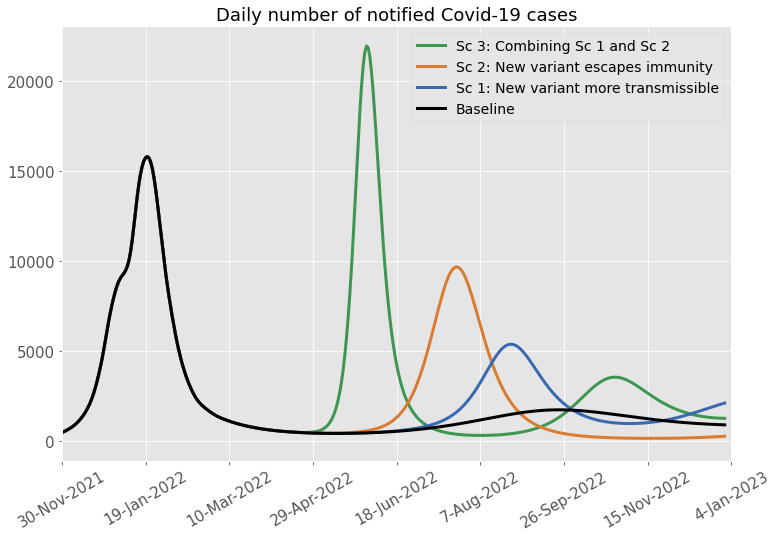

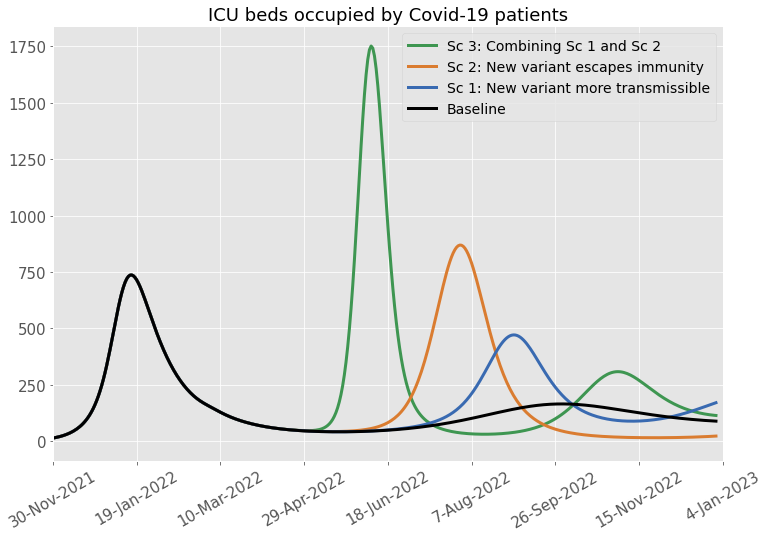

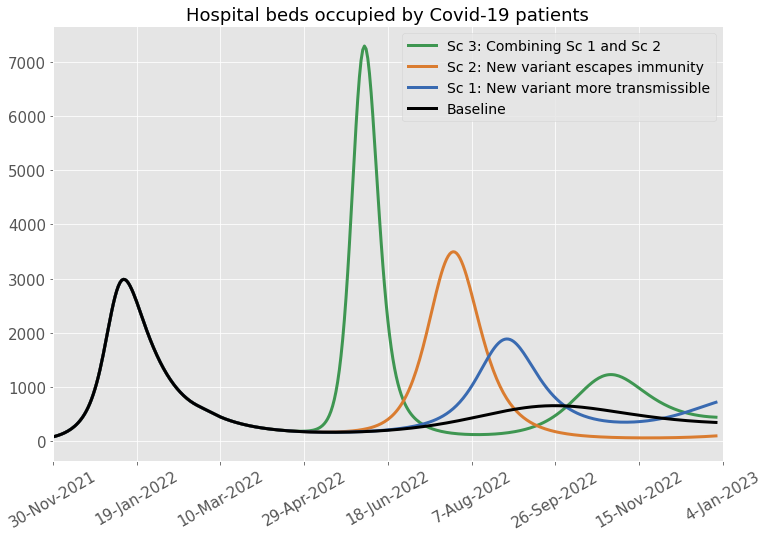

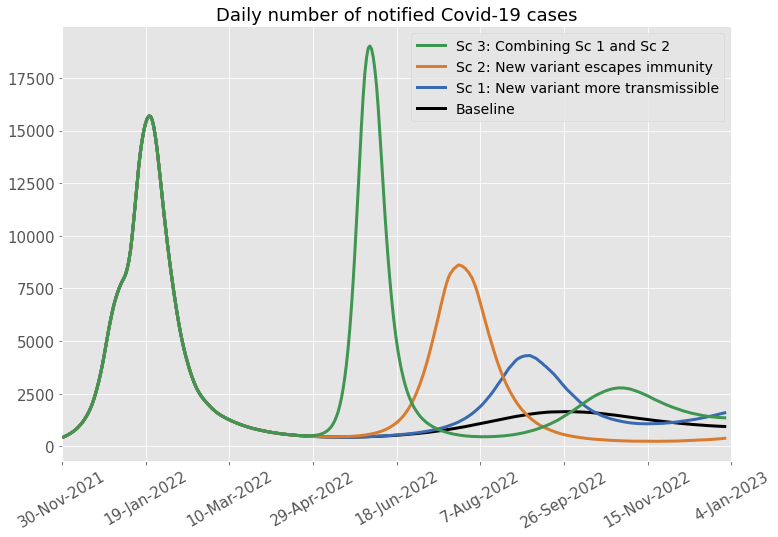

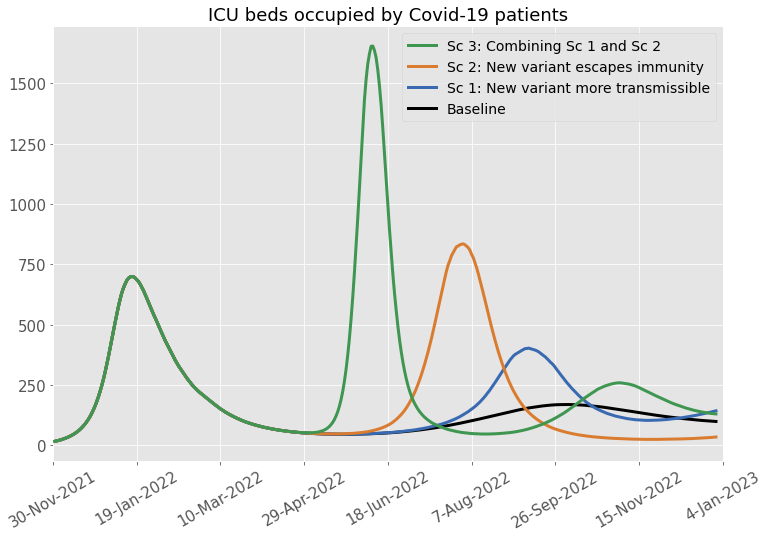

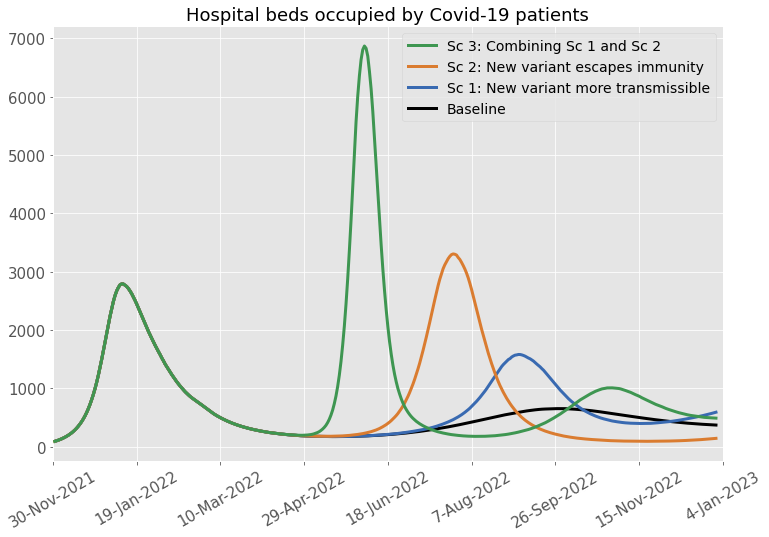

In [10]:
output_names = ["notifications", "icu_occupancy", "hospital_occupancy"]
#output_names = ["incidence", "infection_deaths", "hospital_admissions"]
scenario_x_min, scenario_x_max = 700, 1100 

requested_scenario_list = [3, 2, 1 ,0] # [0, 1, 2, 3]
legend_titles = ["Sc 3: Combining Sc 1 and Sc 2", "Sc 2: New variant escapes immunity", "Sc 1: New variant more transmissible", "Baseline"]

sc_colors = [COLOR_THEME[i] for i in scenario_list]
sc_linestyles = ["solid"] + ["solid"] * (len(scenario_list) - 1)

for output_type in ["MLE", "median"]:
    for output_name in output_names:
        plot_outputs(output_type, output_name, requested_scenario_list, sc_linestyles, sc_colors, False, x_min=scenario_x_min, x_max=scenario_x_max
                    )# cumul_from=426)
        
        plt.legend(legend_titles, fontsize=14)
        
        path = os.path.join(base_dir, output_type, f"{output_name}.png")
        plt.savefig(path)

# Uncertainty around scenarios

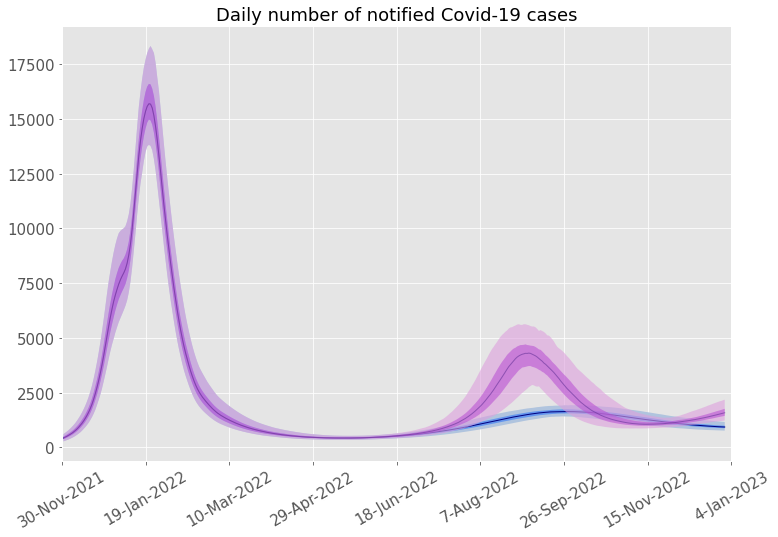

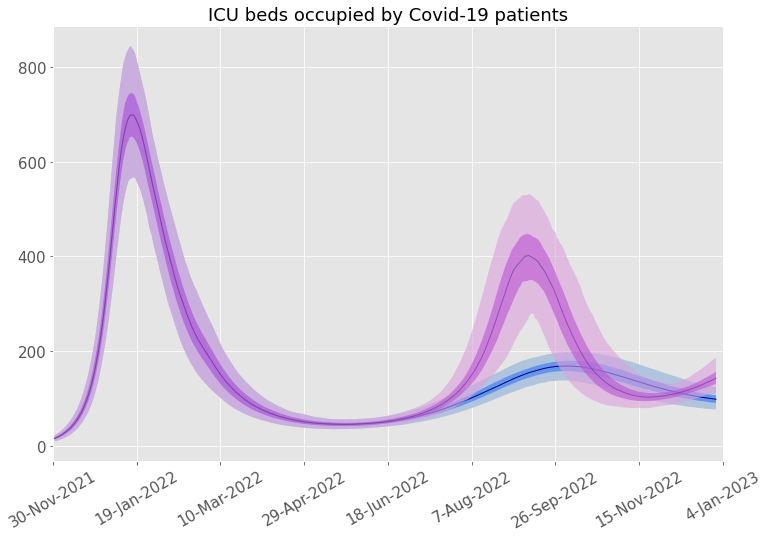

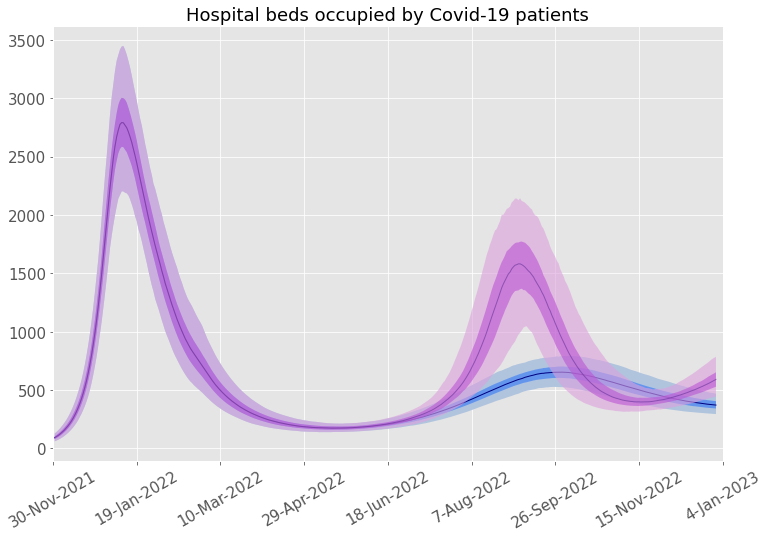

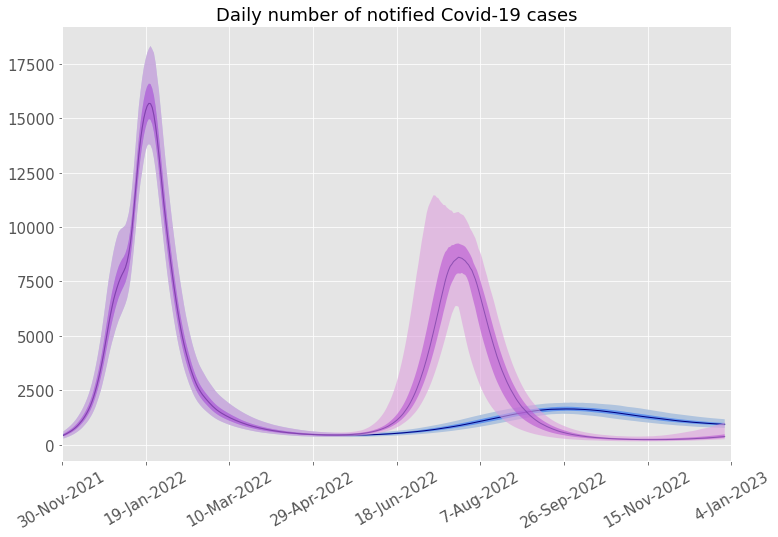

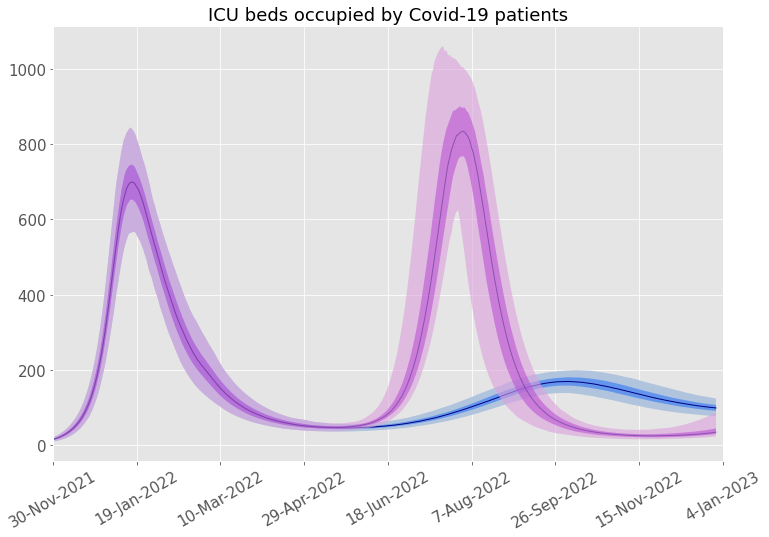

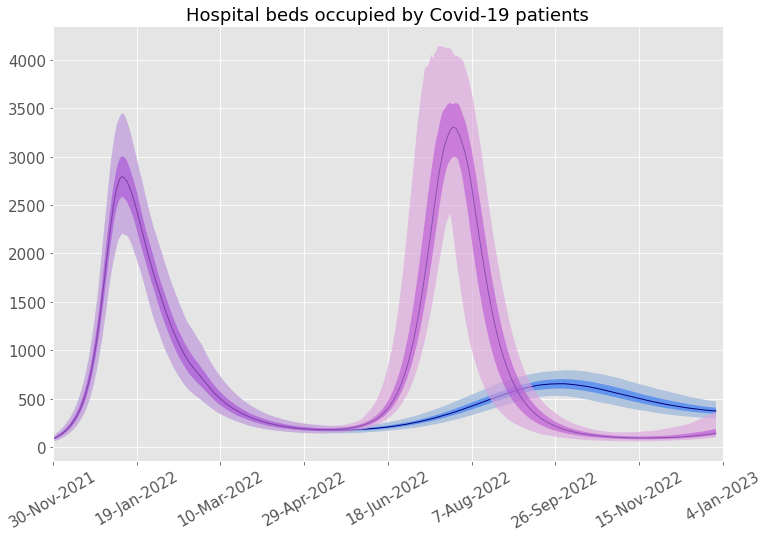

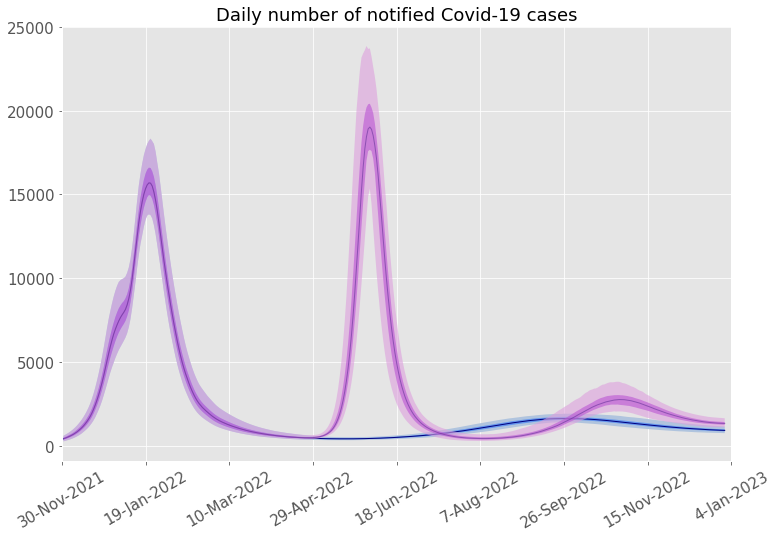

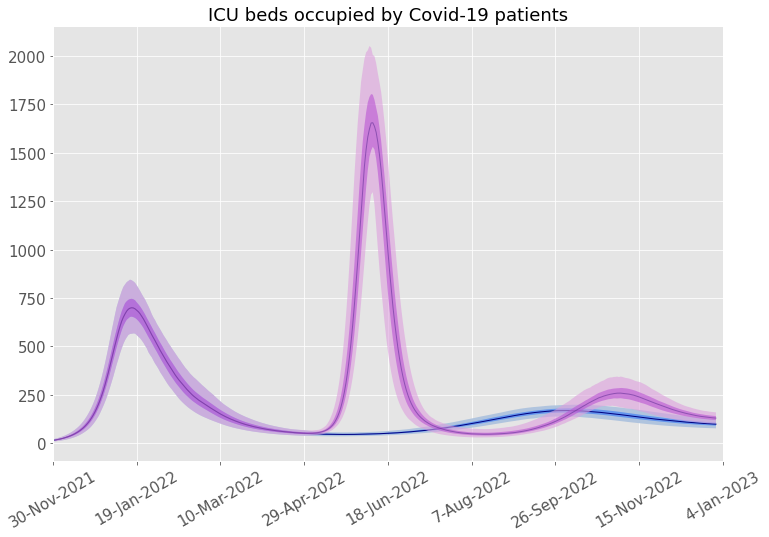

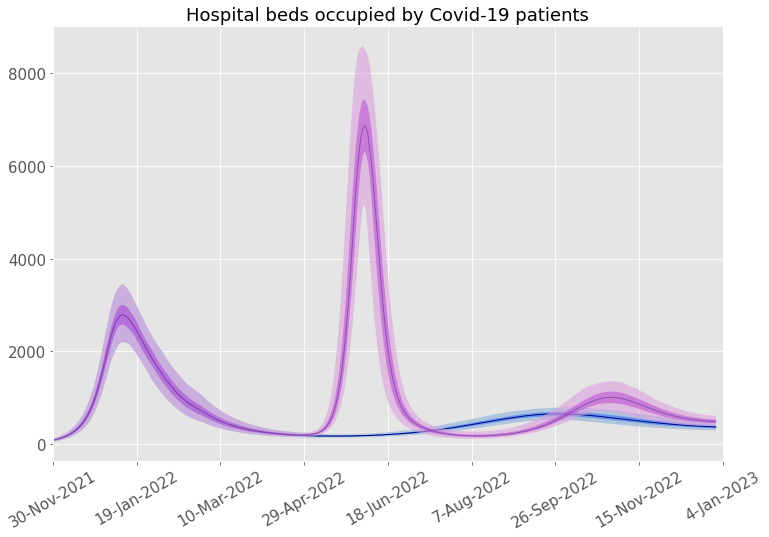

In [11]:
output_type = "uncertainty"
for scenario in scenario_list:
    if scenario == 0:
        continue
    scenarios_to_plot = [0, scenario]
    for output_name in output_names:
        plot_outputs(output_type, output_name, scenarios_to_plot, sc_linestyles, sc_colors, False, x_min=scenario_x_min, x_max=scenario_x_max)
        path = os.path.join(base_dir, output_type, f"{output_name}_scenario_{scenario}.png")
        plt.savefig(path)

# Uncertainty around baseline only (Calibration plots)

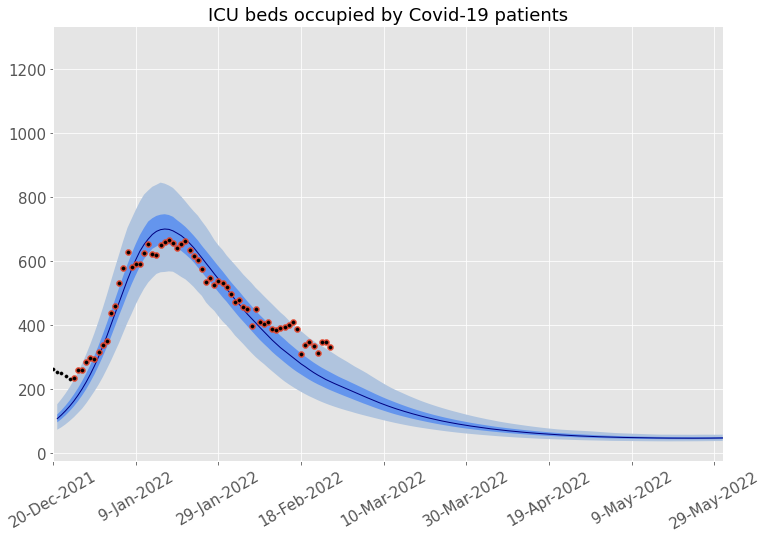

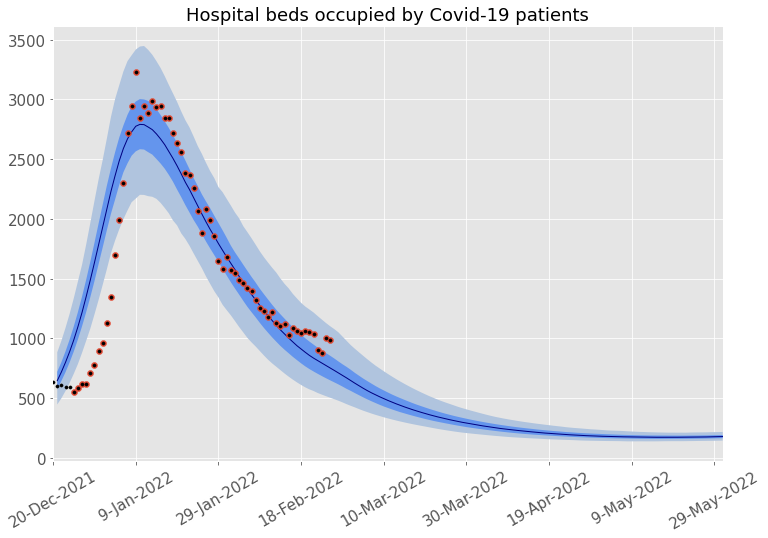

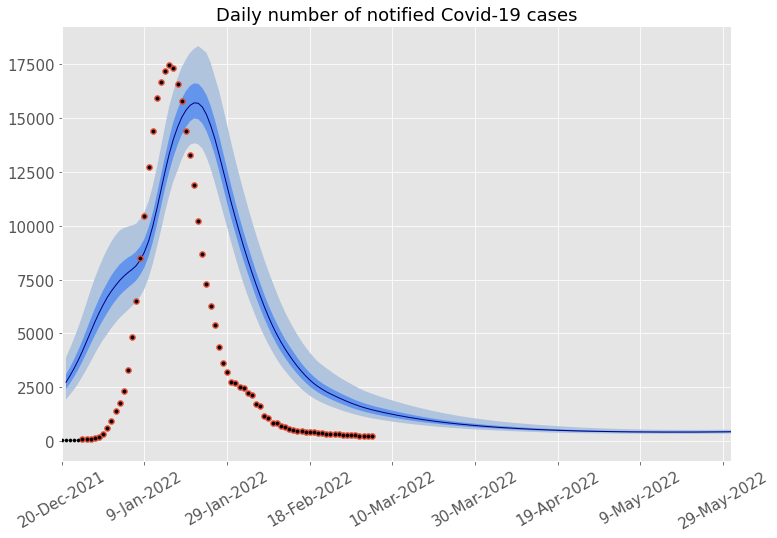

In [12]:
calibration_x_min, calibration_x_max = 720, 882

output_names = ["icu_occupancy", "hospital_occupancy", "notifications"]

for output_name in output_names:
    axis = plot_outputs("uncertainty", output_name, [0], sc_linestyles, sc_colors, False, x_min=calibration_x_min, x_max=calibration_x_max)  
    path = os.path.join(base_dir, 'calibration', f"{output_name}.png")
 
    targets = project.plots
    targets = {k: v for k, v in targets.items() if v["output_key"] == output_name}
    values, times = _get_target_values(targets, output_name)
    _plot_targets_to_axis(axis, values, times, on_uncertainty_plot=True)
    
    trunc_index = times.index(725)
    trunc_times = times[trunc_index:]
    trunc_values = values[trunc_index:]
    
    plt.scatter(trunc_times, trunc_values)
    
    plt.savefig(path)




# Dump outputs to csv files

In [13]:
csv_outputs = ["icu_occupancy", "hospital_occupancy", "notifications"]
start_time = 700

includes_MLE = False
requested_quantiles = [0.025, 0.50, 0.975]

# for age in [str(int(5. * i)) for i in range(16)]:
#     csv_outputs.append(f"notificationsXagegroup_{age}")

def get_uncertainty_data(output_name, scenario_idx, quantile):
    mask = (
            (uncertainty_df["type"] == output_name)
            & (uncertainty_df["scenario"] == scenario_idx)
            & (uncertainty_df["quantile"] == quantile)
        )
    df = uncertainty_df[mask]
    times = df.time.unique()[1:]
    values = df["value"].tolist()[1:]
        
    return times, values

COVID_BASE_DATE = pd.datetime(2019, 12, 31)
start_date = pd.to_timedelta(start_time, unit="days") + (COVID_BASE_DATE)  

for scenario in scenario_list:
    df = pd.DataFrame()
    
    # include a column for the date
    t, _ = get_uncertainty_data("notifications", scenario, 0.5)
    df["date"] = pd.to_timedelta(t, unit="days") + (COVID_BASE_DATE)  
    
    for output in csv_outputs:
        if includes_MLE:
            derived_output_tables = db.load.load_derived_output_tables(calib_path, column=output)
            do_times, do_values = get_output_from_run_id(output, mcmc_tables, derived_output_tables, "MLE", scenario)            
            
            assert list(do_times[1:]) == list(t)
            do_values = list(do_values)[1:]        

            name = f"{output}_MLE"
            df[name] = do_values       
       
        if output in list(uncertainty_df["type"].unique()):
            for quantile in requested_quantiles:
                _, v = get_uncertainty_data(output, scenario, quantile)         
                name = f"{output}_{quantile}"
                df[name] = v            
    
    
    # trim the dataframe to keep requested times only
    df.drop(df[df.date < start_date].index, inplace=True)    
    
    path = os.path.join(base_dir, 'csv_files', f"outputs_scenario_{scenario}.csv")
    df.to_csv(path)
            
